In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.metrics import roc_auc_score, f1_score, plot_confusion_matrix, \
    plot_roc_curve, plot_precision_recall_curve, classification_report, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
from eli5.sklearn import PermutationImportance
import eli5
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import pickle
import warnings

warnings.filterwarnings("ignore")

#### Features
- enrolle_id - Уникальный идентификатор кандидата
- city - Код города
- city_ development _index - Индекс развития города (масштабированный)
- gender - пол кандидата
- relevent_experience - релевантный опыт кандидата
- enrolled_university - тип обучения в университете (если был)
- education_level - уровень образования кандидата
- major_discipline - основная специальность по образованию
- experience - общий стаж кандидата в годах
- company_size - размер компании в работниках
- company_type - тип работодателя
- lastnewjob - дельта в годах между предыдущей и текущей работах
- training_hours - кол-во завершенных часов обучения
- target 0 – Не ищу новую работу
- target 1 – Ищу новую работу
#### Inspiration
Спрогнозируйте вероятность того, что кандидат будет работать на компанию& Features importance

In [2]:
df = pd.read_csv('/home/shaggy/aug_train.csv')
df = df.drop(['enrollee_id', 'city'], axis=1)

test_data = pd.read_csv('/home/shaggy/aug_test.csv')
test_data = test_data.drop(['enrollee_id', 'city'], axis=1)

df.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


# Data exploring

target == 0 - 75.07 %
target == 1 - 24.93 %


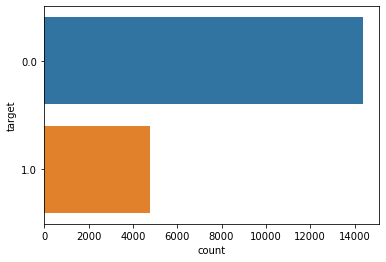

In [3]:
ax = sns.countplot(y='target', data=df)
total = df.target.shape[0]

target_0_percent = round(df[df['target'] == 0].shape[0] / total * 100, 2)
target_1_percent = round(df[df['target'] == 1].shape[0] / total * 100, 2)

print('target == 0 -', target_0_percent, '%')
print('target == 1 -',target_1_percent, '%')

In [4]:
df.isna().mean()*100

city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

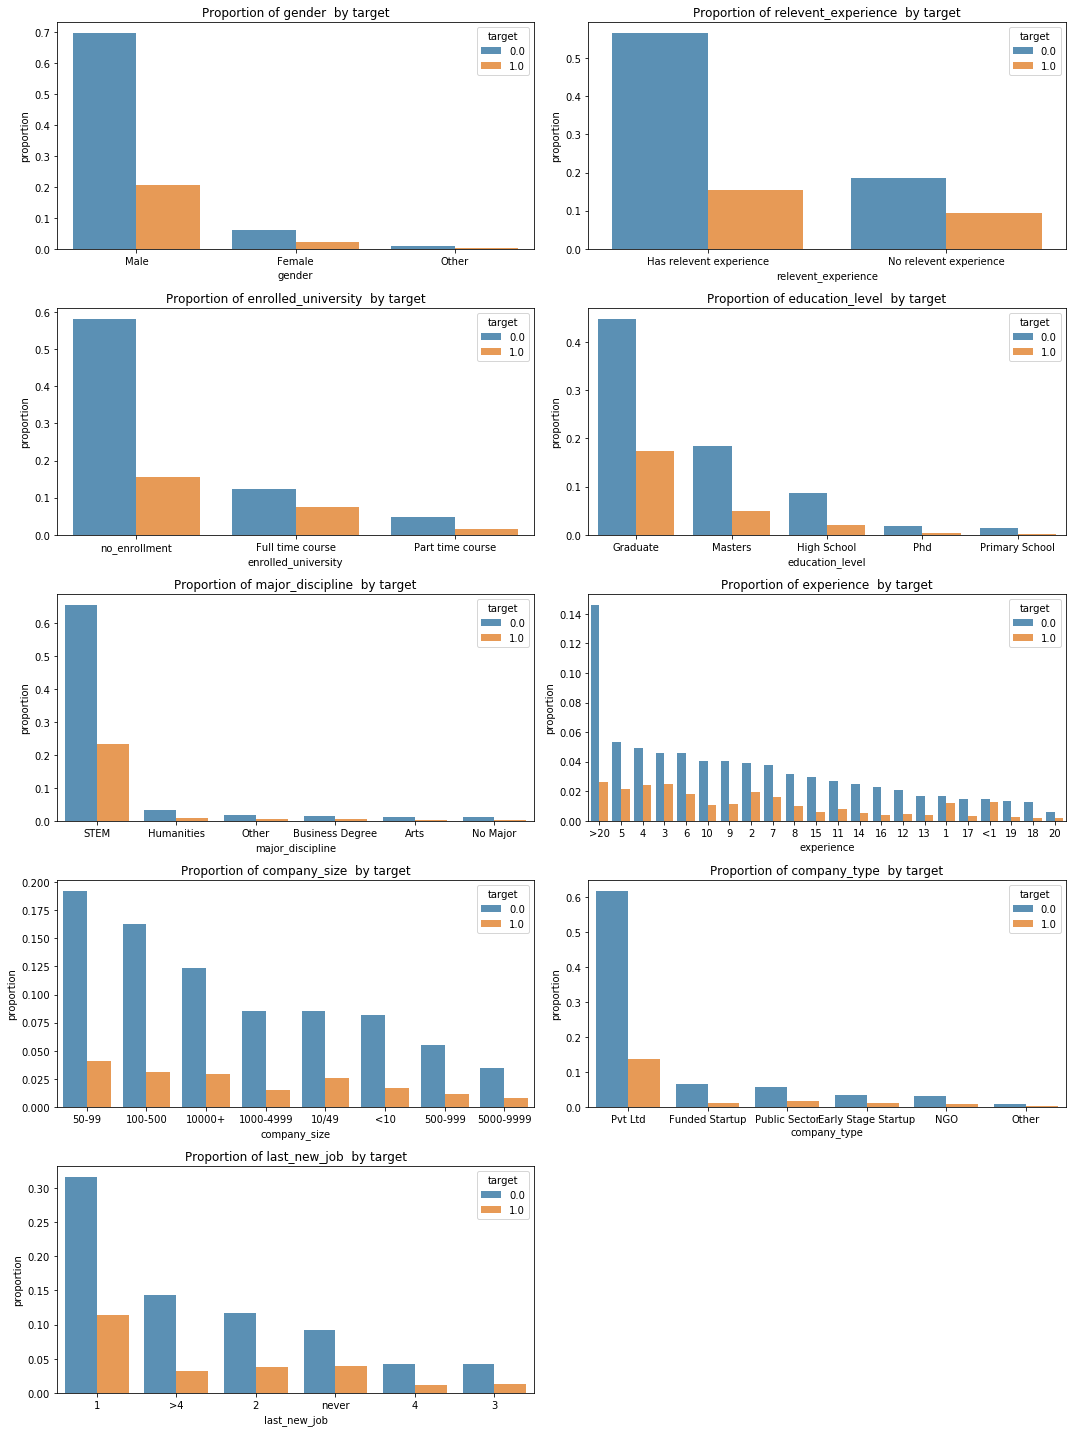

In [5]:
#выбираем признаки типа объект
cols_obj = list(df.dtypes[df.dtypes == object].index[:])

#строим графики признаков типа объект от значения таргета, отнормируем на размер датасета
plt.figure(figsize=[15, 20])

i = 1
y, hue = "proportion", "target"

for f in cols_obj:
    plt.subplot(5, 2, i)
    df[[f, 'target']]\
        .value_counts(normalize=True)\
        .rename(y)\
        .reset_index()\
        .pipe((sns.barplot, "data"), x=f, y='proportion', hue='target', alpha=0.8)
    plt.title("Proportion of {}  by target".format(f))
    i += 1
# чтобы графики не заезжали друг на друга
plt.tight_layout()

Больше всех работу ищут:
- мужчины
- студенты
- STEM
- Pvt Ltd
- Имеющие опыт работы в 1 компании

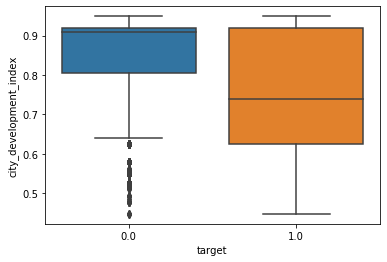

In [6]:
sns.boxplot(x='target', y='city_development_index', data=df)

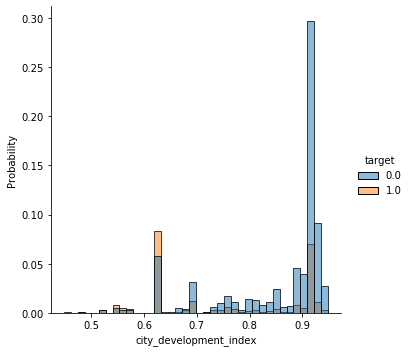

In [7]:
sns.displot(x='city_development_index',
            hue='target',
            data=df,
            stat="probability")

Больше всего ищут жители небольших городов

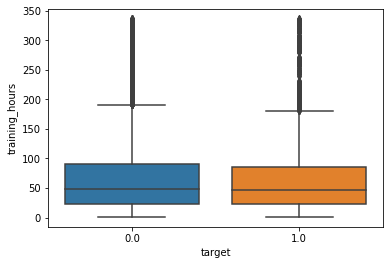

In [8]:
sns.boxplot(x='target', y='training_hours', data=df)

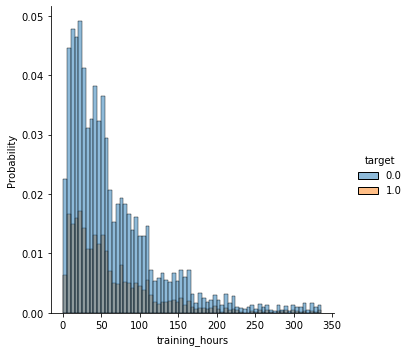

In [9]:
sns.displot(x='training_hours',
            hue='target',
            data=df,
            stat="probability")

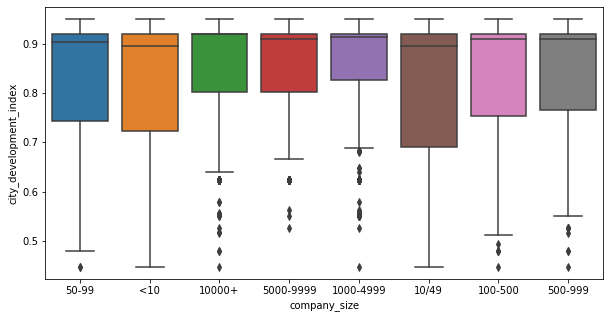

In [10]:
plt.figure(figsize=[10, 5])
sns.boxplot(x='company_size', y='city_development_index', data=df)

У больших компаний выше индекс развития

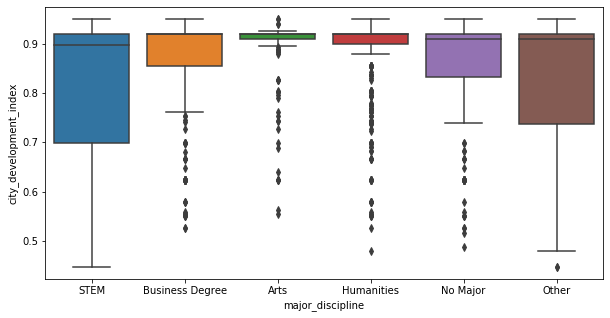

In [11]:
plt.figure(figsize=[10, 5])
sns.boxplot(x='major_discipline', y='city_development_index', data=df)

Некоторые дисциплины доступны только в больших городах

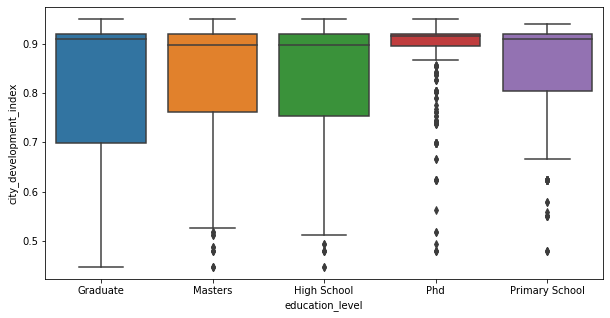

In [12]:
plt.figure(figsize=[10, 5])
sns.boxplot(x='education_level', y='city_development_index', data=df)

In [13]:
def get_status_category(x, y):
    if ((x in ['1', '2', '3', '4', '5', '6', '<1', '7', '8']) &
            ((y in ['Phd']) | (y in ['Masters']) | (y in ['Graduate']))):
        return 'junior'
    elif ((x in ['1', '2', '3', '<1']) & (y != 'Phd') & (y != 'Masters') &
          (y != 'Graduate')):
        return 'intern'
    elif (x in ['9', '10', '11', '12', '13', '14', '15']):
        return 'middle'
    elif (x in ['16', '17', '18', '19', '20', '>20']):
        return 'senior'

df['Status'] = df.apply(lambda row: get_status_category(row['experience'], row['education_level']), axis=1)

df.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,Status
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0,senior
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,middle
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0,junior
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0,junior
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0,senior


In [14]:
for i in df.isna().mean()[df.isna().mean() > 0].index:
    print(i, df[i].unique(), '\n')

gender ['Male' nan 'Female' 'Other'] 

enrolled_university ['no_enrollment' 'Full time course' nan 'Part time course'] 

education_level ['Graduate' 'Masters' 'High School' nan 'Phd' 'Primary School'] 

major_discipline ['STEM' 'Business Degree' nan 'Arts' 'Humanities' 'No Major' 'Other'] 

experience ['>20' '15' '5' '<1' '11' '13' '7' '17' '2' '16' '1' '4' '10' '14' '18'
 '19' '12' '3' '6' '9' '8' '20' nan] 

company_size [nan '50-99' '<10' '10000+' '5000-9999' '1000-4999' '10/49' '100-500'
 '500-999'] 

company_type [nan 'Pvt Ltd' 'Funded Startup' 'Early Stage Startup' 'Other'
 'Public Sector' 'NGO'] 

last_new_job ['1' '>4' 'never' '4' '3' '2' nan] 

Status ['senior' 'middle' 'junior' None 'intern'] 



In [15]:
for i in df.isna().mean()[df.isna().mean() > 0].index:
    df[i] = df[i].fillna('None')

# Modeling

In [22]:
X = pd.get_dummies(df, columns=df.dtypes[df.dtypes == object].index).drop(
    ['target'], axis=1)
y = df.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=10)

In [23]:
def get_scores(report_df, model, X_test, y_test, name):

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_0'] = precision_score(
        y_test, model.predict(X_test), pos_label=0)
    report['precision_1'] = precision_score(
        y_test, model.predict(X_test), pos_label=1)
    report['recall_0'] = recall_score(
        y_test, model.predict(X_test), pos_label=0)
    report['recall_1'] = recall_score(
        y_test, model.predict(X_test), pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [ ]:
df_report = pd.DataFrame()

## Random Forest

In [25]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

df_report = get_scores(df_report, rf, X_test, y_test, 'RandomForestClassifier')

In [26]:
df_report

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1
RandomForestClassifier,0.776683,0.491127,0.827418,0.567627,0.891877,0.432798


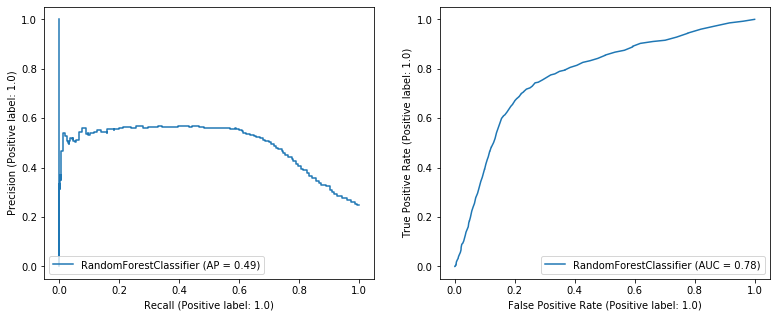

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

plot_precision_recall_curve(rf, X_test,y_test, ax=ax1)
plot_roc_curve(rf, X_test,y_test, ax=ax2)

Стратификация — метод выбора подмножества объектов из генеральной совокупности, разбитой на подмножества (страты). При стратификации объекты выбираются таким образом, чтобы итоговая выборка сохраняла соотношения размеров страт. 

Стратификацию разумно применять при любом семплинге. В машинном обучении стратификация бывает полезна как на этапе сбора данных, так в процессе кросс-валидации .

In [28]:
# Grid Search
# Так как классы разабалансированны применим стратификацию
rf_skf = RandomForestClassifier(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'bootstrap': [True, False],
         'max_depth': range(5, 40, 5),
         'n_estimators': range(500, 1000, 100)}

clf_rf = GridSearchCV(
    rf_skf, param, scoring='roc_auc', refit=True, cv=skf, verbose=3, n_jobs=-1)
clf_rf.fit(X_train, y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_rf.best_score_, clf_rf.best_params_))

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best roc_auc: 0.7846, with best C: {'bootstrap': True, 'max_depth': 15, 'n_estimators': 600}


In [29]:
df_report = get_scores(df_report, clf_rf, X_test, y_test, 'RandomForestClassifierCLF')

In [30]:
df_report

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1
RandomForestClassifier,0.776683,0.491127,0.827418,0.567627,0.891877,0.432798
RandomForestClassifierCLF,0.795545,0.612639,0.890649,0.546782,0.810646,0.696534


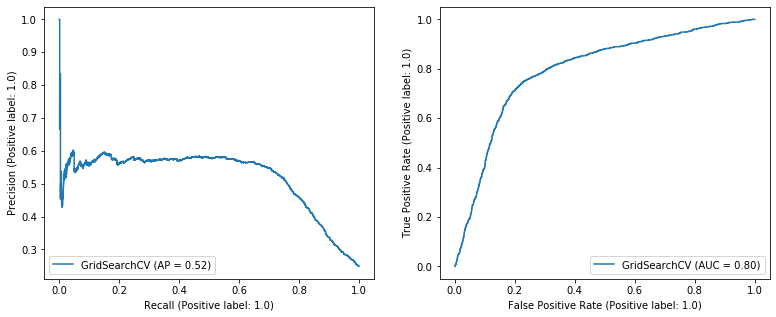

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

plot_precision_recall_curve(clf_rf, X_test,y_test, ax=ax1)
plot_roc_curve(clf_rf, X_test,y_test, ax=ax2)

При поиске наилучших параметров мы улучшили все пказатели, кроме точности 1 класса. 

## Lightgbm

Данный алгоритм отрабатывает быстрее чем xgboost, а также умеет работать с категориальными переменными

In [40]:
X_ = df.drop(['target'], axis=1)
y_ = df['target']

for c in X_.columns:
    col_type = X_[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_[c] = X_[c].astype('category')

In [42]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X_, y_, test_size=0.25, random_state=10)

In [43]:
lgb = LGBMClassifier()
lgb.fit(X_train_, y_train_, categorical_feature='auto')

LGBMClassifier()

In [44]:
df_report = get_scores(df_report, lgb, X_test_,
                       y_test_, 'LGBMClassifier')

In [45]:
df_report

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1
RandomForestClassifier,0.776683,0.491127,0.827418,0.567627,0.891877,0.432798
RandomForestClassifierCLF,0.795545,0.612639,0.890649,0.546782,0.810646,0.696534
LGBMClassifier,0.802021,0.581247,0.862279,0.583475,0.864430,0.579036
LGBMClassifier,0.797888,0.573854,0.859829,0.576300,0.862212,0.571429


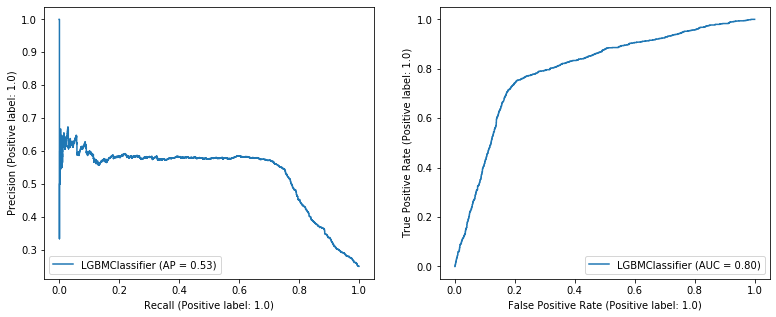

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

plot_precision_recall_curve(lgb, X_test_, y_test_, ax=ax1)
plot_roc_curve(lgb, X_test_, y_test_, ax=ax2);

In [47]:
# Grid Search
lgb_skf = LGBMClassifier(class_weight='balanced', categorical_feature='auto')
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'learning_rate': np.arange(0.005, 0.1, 0.01),
         'num_leaves': range(30, 100, 10),
         'n_estimators': range(500, 1000, 100)}

clf_lgb = GridSearchCV(lgb_skf, param, scoring='roc_auc',
                       cv=skf, verbose=3, n_jobs=-1)
clf_lgb.fit(X_train_, y_train_)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_lgb.best_score_, clf_lgb.best_params_))

Fitting 5 folds for each of 350 candidates, totalling 1750 fits
Best roc_auc: 0.7916, with best C: {'learning_rate': 0.005, 'n_estimators': 900, 'num_leaves': 30}


In [48]:
df_report = get_scores(df_report, clf_lgb, X_test_,
                       y_test_, 'LGBMClassifierCLF')

In [49]:
df_report

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1
RandomForestClassifier,0.776683,0.491127,0.827418,0.567627,0.891877,0.432798
RandomForestClassifierCLF,0.795545,0.612639,0.890649,0.546782,0.810646,0.696534
LGBMClassifier,0.802021,0.581247,0.862279,0.583475,0.864430,0.579036
LGBMClassifier,0.797888,0.573854,0.859829,0.576300,0.862212,0.571429
LGBMClassifierCLF,0.802169,0.634852,0.904896,0.554643,0.804547,0.742181


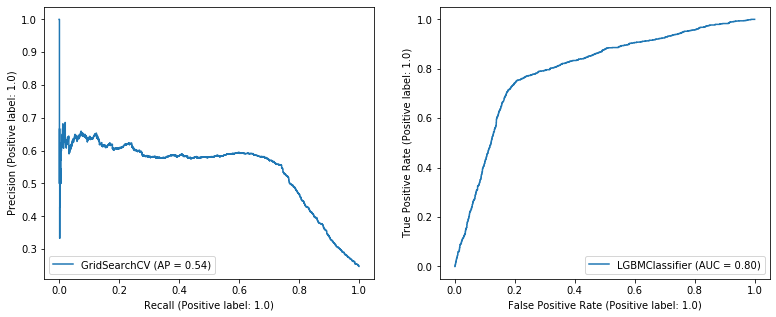

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

plot_precision_recall_curve(clf_lgb, X_test_, y_test_, ax=ax1)
plot_roc_curve(lgb, X_test_, y_test_, ax=ax2);

In [52]:
oversample = RandomOverSampler(sampling_strategy=1.0)
X_over_, y_over_ = oversample.fit_resample(X_train_, y_train_)

In [54]:
# Grid Search
lgb_skf = LGBMClassifier(categorical_feature='auto')
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'learning_rate': np.arange(0.005, 0.1, 0.01),
         'num_leaves': range(30, 100, 10),
         'n_estimators': range(500, 1000, 100)}

clf_lgb_over = GridSearchCV(lgb_skf, param, scoring='roc_auc',
                            cv=skf, verbose=3, n_jobs=-1)
clf_lgb_over.fit(X_over_, y_over_)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_lgb_over.best_score_, clf_lgb_over.best_params_))

Fitting 5 folds for each of 350 candidates, totalling 1750 fits
Best roc_auc: 0.9607, with best C: {'learning_rate': 0.09499999999999999, 'n_estimators': 900, 'num_leaves': 90}


In [55]:
df_report = get_scores(df_report, clf_lgb_over, X_test_,
                       y_test_, 'LGBMClassifierCLF_LGB')

In [56]:
df_report

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1
RandomForestClassifier,0.776683,0.491127,0.827418,0.567627,0.891877,0.432798
RandomForestClassifierCLF,0.795545,0.612639,0.890649,0.546782,0.810646,0.696534
LGBMClassifier,0.802021,0.581247,0.862279,0.583475,0.864430,0.579036
LGBMClassifier,0.797888,0.573854,0.859829,0.576300,0.862212,0.571429
LGBMClassifierCLF,0.802169,0.634852,0.904896,0.554643,0.804547,0.742181
LGBMClassifierCLF_LGB,0.780405,0.549618,0.852006,0.551489,0.853895,0.547760


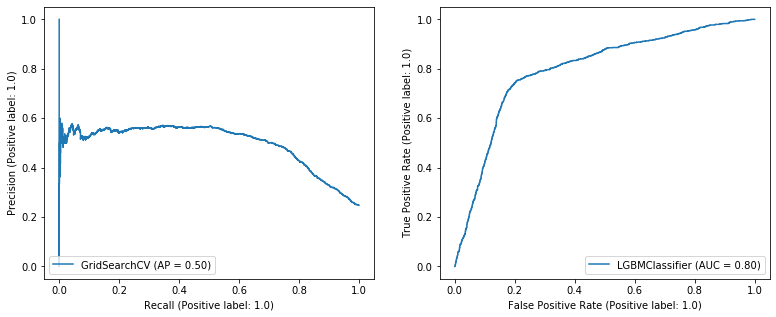

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

plot_precision_recall_curve(clf_lgb_over, X_test_, y_test_, ax=ax1)
plot_roc_curve(lgb, X_test_, y_test_, ax=ax2);

Как видно из таблицы, лучший резульат получается при поиске лучших параметров у Lightgbm. Увеличение объектов недостающего класса негативно сказалось на LGBMClassifier.

## Stacking

Попробуем применить стекинг над моделями, объединим разные модели, у которых f1 более 60%

Посмотрим, можем ли мы улучшить производительность, комбинируя предсказания моделей с помощью "soft voting".

Soft voting - это argmax суммы предсказанных вероятностей.

In [61]:
oversample = RandomOverSampler(sampling_strategy=1.0)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [62]:
lgbm_ = LGBMClassifier(learning_rate=0.01, n_estimators=900, num_leaves=30)
rf_ = RandomForestClassifier(bootstrap=True, max_depth=15, n_estimators=600)

clf_st = VotingClassifier(estimators=[
    ('rf', rf_), ('lgb', lgbm_)], voting='soft')

clf_st.fit(X_over.values, y_over.values)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=600)),
                             ('lgb',
                              LGBMClassifier(learning_rate=0.01,
                                             n_estimators=900,
                                             num_leaves=30))],
                 voting='soft')

In [64]:
df_report = get_scores(df_report, clf_st, X_test,
                       y_test, 'VotingClassifier')

In [65]:
df_report

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1
RandomForestClassifier,0.776683,0.491127,0.827418,0.567627,0.891877,0.432798
RandomForestClassifierCLF,0.795545,0.612639,0.890649,0.546782,0.810646,0.696534
LGBMClassifier,0.802021,0.581247,0.862279,0.583475,0.864430,0.579036
LGBMClassifier,0.797888,0.573854,0.859829,0.576300,0.862212,0.571429
LGBMClassifierCLF,0.802169,0.634852,0.904896,0.554643,0.804547,0.742181
LGBMClassifierCLF_LGB,0.780405,0.549618,0.852006,0.551489,0.853895,0.547760
VotingClassifier,0.804206,0.632192,0.902386,0.555342,0.807319,0.733728


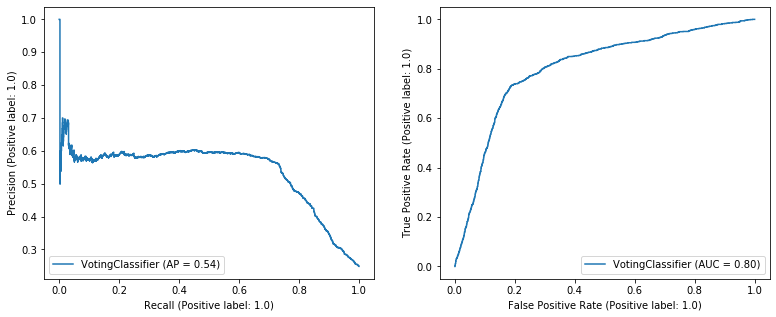

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

plot_precision_recall_curve(clf_st, X_test, y_test, ax=ax1)
plot_roc_curve(clf_st, X_test, y_test, ax=ax2);

При помощи VotingClassifier не получилось добиться наилучшего результата. Резульаты оказались сопоставимы с моделью LGBMClassifierCLF.

## Permutation feature importance
Измерение важности признако за счет перестановок внутри одной фичи (например, строки): если после перестановки ошибка модели увеличилась, то фича "важна", если ошибка произошла без изменений, то "неважна".

In [70]:
perm = PermutationImportance(clf_st, scoring='f1').fit(X_test, y_test)

In [71]:
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.2303 ± 0.0107,city_development_index
0.0879 ± 0.0075,company_size_None
0.0084 ± 0.0076,company_type_Pvt Ltd
0.0049 ± 0.0025,relevent_experience_Has relevent experience
0.0039 ± 0.0030,company_type_None
0.0039 ± 0.0039,Status_junior
0.0038 ± 0.0023,enrolled_university_no_enrollment
0.0036 ± 0.0029,last_new_job_never
0.0033 ± 0.0036,training_hours
0.0030 ± 0.0010,relevent_experience_No relevent experience


Наиболее важной фичей оказался индекс развития города